# Zajęcie 5: Metoda BPTT dla sieci LSTM

### Importowanie

In [26]:
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

### Odczytywanie i przetwarzanie danych

In [27]:
#data = open('input.txt', 'r').read()
data = open('example2.txt', 'r').read()

Przetwarzaj dane i obliczaj indeksy

In [28]:
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 385 characters, 40 unique


### Stałe i hiperparametry

In [29]:
H_size = 10 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

### Funkcje aktywacji i pochodne

#### Sigmoid

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}}\\
\frac{d\sigma(x)}{dx} &= \sigma(x) \cdot (1 - \sigma(x))
\end{align}

#### Tanh

\begin{align}
\frac{d\text{tanh}(x)}{dx} &= 1 - \text{tanh}^2(x)
\end{align}

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

### Parametry

In [31]:
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad

Używamy losowych wag z rozkładem normalnym (`0`, `weight_sd`) dla funkcji aktywacji $tanh$ i (`0.5`, `weight_sd`) dla funkcji aktywacji $sigmoid$.

Odchylenia są inicjowane do zera.

In [32]:
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

### Obliczanie do przodu

![LSTM](http://blog.varunajayasiri.com/ml/lstm.svg)

*Operacja $z$ to konkatenacja $x$ i $h_{t-1}$*

#### Konkatenacja $h_{t-1}$ i $x_t$
\begin{align}
z & = [h_{t-1}, x_t] \\
\end{align}

#### Funkcje LSTM
\begin{align}
f_t & = \sigma(W_f \cdot z + b_f) \\
i_t & = \sigma(W_i \cdot z + b_i) \\
\bar{C}_t & = tanh(W_C \cdot z + b_C) \\
C_t & = f_t * C_{t-1} + i_t * \bar{C}_t \\
o_t & = \sigma(W_o \cdot z + b_t) \\
h_t &= o_t * tanh(C_t) \\
\end{align}

#### Logits
\begin{align}
v_t &= W_v \cdot h_t + b_v \\
\end{align}

#### Softmax
\begin{align}
\hat{y_t} &= \text{softmax}(v_t)
\end{align}

$\hat{y_t}$ to `y` w kodzie i $y_t$ to `targets`.


In [33]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

### Oblicznie wsztecz

#### Loss

\begin{align}
L_k &= -\sum_{t=k}^T\sum_j y_{t,j} log \hat{y_{t,j}} \\
L &= L_1 \\
\end{align}

#### Gradients

\begin{align}
dv_t &= \hat{y_t} - y_t \\
dh_t &= dh'_t + W_y^T \cdot dv_t \\
do_t &= dh_t * \text{tanh}(C_t) \\
dC_t &= dC'_t + dh_t * o_t * (1 - \text{tanh}^2(C_t))\\
d\bar{C}_t &= dC_t * i_t \\
di_t &= dC_t * \bar{C}_t \\
df_t &= dC_t * C_{t-1} \\
\\
df'_t &= f_t * (1 - f_t) * df_t \\
di'_t &= i_t * (1 - i_t) * di_t \\
d\bar{C}'_{t-1} &= (1 - \bar{C}_t^2) * d\bar{C}_t \\
do'_t &= o_t * (1 - o_t) * do_t \\
dz_t &= W_f^T \cdot df'_t \\
     &+ W_i^T \cdot di_t \\
     &+ W_C^T \cdot d\bar{C}_t \\
     &+ W_o^T \cdot do_t \\
\\
[dh'_{t-1}, dx_t] &= dz_t \\
dC'_t &= f_t * dC_t
\end{align}

* $dC'_t = \frac{\partial L_{t+1}}{\partial C_t}$ and $dh'_t = \frac{\partial L_{t+1}}{\partial h_t}$
* $dC_t = \frac{\partial L}{\partial C_t} = \frac{\partial L_t}{\partial C_t}$ and $dh_t = \frac{\partial L}{\partial h_t} = \frac{\partial L_{t}}{\partial h_t}$
* All other derivatives are of $L$
* `target` is target character index $y_t$
* `dh_next` is $dh'_{t}$ (size H x 1)
* `dC_next` is $dC'_{t}$ (size H x 1)
* `C_prev` is $C_{t-1}$ (size H x 1)
* $df'_t$, $di'_t$, $d\bar{C}'_t$, and $do'_t$ are *also* assigned to `df`, `di`, `dC_bar`, and `do` in the **code**.
* *Returns* $dh_t$ and $dC_t$

#### Gradienty parametrów modelu

\begin{align}
dW_v &= dv_t \cdot h_t^T \\
db_v &= dv_t \\
\\
dW_f &= df'_t \cdot z^T \\
db_f &= df'_t \\
\\
dW_i &= di'_t \cdot z^T \\
db_i &= di'_t \\
\\
dW_C &= d\bar{C}'_t \cdot z^T \\
db_C &= d\bar{C}'_t \\
\\
dW_o &= do'_t \cdot z^T \\
db_o &= do'_t \\
\\
\end{align}

In [34]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

### Oblicznie do przodu i wstecz

Wyczyść gradienty przed każdym obliczniem wstecz

In [35]:
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

Przycinaj gradienty, aby złagodzić wybuchające gradienty

In [36]:
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

Oblicz i zapisz wartości w obliczeniu do przodu. Akumuluj gradienty w obliczeniach wstecz i przycinaj gradienty, aby uniknąć wybuchających gradientów.
* `input`, `target` to lista liczb całkowitych z indeksami znaków.
* `h_prev` jest tablicą początkowych `h` dla $h_{-1}$ (size H x 1)
* `C_prev` jest tablicą inicjałów `C` dla $C_{-1}$ (size H x 1)
* *Returns* loss, final $h_T$ and $C_T$

In [37]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

### Wypróbuj następną literę

In [38]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

## Uczenie (Adagrad)

Zaktualizuj wykres i wyświetl przykładowe dane wyjściowe

In [39]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

Zaktualizuj parametry
\begin{align}
\theta_i &= \theta_i - \eta\frac{d\theta_i}{\sum dw_{\tau}^2} \\
d\theta_i &= \frac{\partial L}{\partial \theta_i}
\end{align}

In [40]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

Aby opóźnić przerwanie klawiatury, aby zapobiec zatrzymaniu uczenia w trakcie iteracji

In [41]:
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [42]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

Pętla uczenia

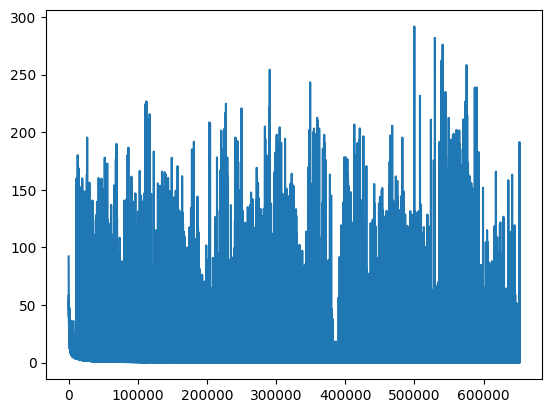

----
 uself-drs (such as Siri and Alexa), self-dringivaneses (such as ch (se.g., Goog, lWaIat lurearoms (such as ches (e.g., Google Search), recommendation systems (used by YouTube, Amazon, and Netflix), un 
----
iter 651910, loss 0.883327


In [43]:
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_idx[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            if loss < 0.1:
                update_status(inputs, g_h_prev, g_C_prev)
                break
    
            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

### Sprawdzanie gradientu

Przybliż gradienty numeryczne, zmieniając parametry i uruchamiając model. Sprawdź, czy przybliżone gradienty są równe obliczonym gradientom analitycznym (przez wsteczną propagację).

Wypróbuj to na `num_checks` pojedynczych parametrach wybranych losowo dla każdej macierzy wag i wektora odchylenia.

In [48]:
from random import uniform

Oblicz gradient numeryczny

In [49]:
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

Sprawdź gradient każdej macierzy parametrów/wektora przy poszczególnych wartościach `num_checks`

In [50]:
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [51]:
gradient_check(10, 1e-5, inputs, targets, g_h_prev, g_C_prev)

W_o (-4.367527e-03, -4.367277e-03) => 2.868727e-05
W_o (-1.218012e-05, -1.217834e-05) => 7.340915e-05
W_o (-9.548415e-05, -9.542676e-05) => 3.006547e-04
W_o (-1.850807e-02, -1.850772e-02) => 9.337523e-06
W_v (2.310657e-01, 2.310667e-01) => 1.958179e-06
W_v (5.529779e-02, 5.529739e-02) => 3.617620e-06
W_v (3.746976e-05, 3.746764e-05) => 2.825184e-05
W_v (-3.676286e-03, -3.676239e-03) => 6.279322e-06
W_v (2.923684e-04, 2.923673e-04) => 1.873466e-06
W_v (-1.194451e-04, -1.194458e-04) => 3.097091e-06
b_i (-8.338185e-01, -8.338258e-01) => 4.359512e-06
b_i (-8.338185e-01, -8.338258e-01) => 4.359512e-06
b_o (1.229314e-03, 1.341056e-03) => 4.347295e-02
b_v (-7.867718e-01, -7.867701e-01) => 1.074120e-06
b_v (4.080900e-01, 4.080889e-01) => 1.400697e-06
b_v (7.111893e-04, 7.111874e-04) => 1.380810e-06
b_v (1.595043e-02, 1.595036e-02) => 1.909410e-06
b_v (1.595043e-02, 1.595036e-02) => 1.909410e-06


## Zadanie

Opracować sieć LSTM w celu nauczanie się tekstu z dokładnością 0.1
Warianty zadania:
1. "Artificial intelligence (AI) is intelligence—perceiving, synthesizing, and inferring information—demonstrated by machines, as opposed to intelligence displayed by non-human animals or by humans"
2. "Example tasks in which this is done include speech recognition, computer vision, translation between (natural) languages, as well as other mappings of inputs"
3. "AI applications include advanced web search engines (e.g., Google Search), recommendation systems (used by YouTube, Amazon, and Netflix), understanding human speech (such as Siri and Alexa), self-driving cars (e.g., Waymo), generative or creative tools (ChatGPT and AI art), automated decision-making, and competing at the highest level in strategic game systems (such as chess and Go)"
4. "As machines become increasingly capable, tasks considered to require "intelligence" are often removed from the definition of AI, a phenomenon known as the AI effect"
5. "Artificial intelligence was founded as an academic discipline in 1956, and in the years since it has experienced several waves of optimism,followed by disappointment and the loss of funding (known as an "AI winter"), followed by new approaches, success, and renewed funding"
6. "AI research has tried and discarded many different approaches, including simulating the brain, modeling human problem solving, formal logic, large databases of knowledge, and imitating animal behavior"
7. "In the first decades of the 21st century, highly mathematical and statistical machine learning has dominated the field, and this technique has proved highly successful, helping to solve many challenging problems throughout industry and academia"
8. "The various sub-fields of AI research are centered around particular goals and the use of particular tools. The traditional goals of AI research include reasoning, knowledge representation, planning, learning, natural language processing, perception, and the ability to move and manipulate objects"
9. "General intelligence (the ability to solve an arbitrary problem) is among the field's long-term goals. To solve these problems, AI researchers have adapted and integrated a wide range of problem-solving techniques, including search and mathematical optimization, formal logic, artificial neural networks, and methods based on statistics, probability, and economics"
10. " Computer scientists and philosophers have since suggested that AI may become an existential risk to humanity if its rational capacities are not steered towards beneficial goals"